# 월간 데이콘 뉴스 토픽 분류 AI 경진대회

In [1]:
# 할당된 gpu 확인
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
NVIDIA GeForce RTX 3080 Ti, 531.41, 12288 MiB


## 필요 모듈 사용

In [2]:
import os
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from konlpy.tag import Kkma
from konlpy.utils import pprint

import pickle
import joblib

import utils as _utils

utils = _utils.Utils()
kkma = Kkma()

## 데이터 확인

### 원본 파일 리스트 확인

In [3]:
%cd ./datas/original
!dir
%cd ../../

h:\내 드라이브\Colab Notebooks\proj\study\DaheeT\assignment\news_topic_classification2\datas\original
 H ����̺��� ����: ptjkjm1@gmail.com - Google Drive
 ���� �Ϸ� ��ȣ: 1983-1116

 h:\�� ����̺�\Colab Notebooks\proj\study\DaheeT\assignment\news_topic_classification2\datas\original ���͸�

2023-04-28  ���� 01:05    <DIR>          .
2023-04-28  ���� 04:10    <DIR>          ..
2021-06-23  ���� 12:35            82,196 sample_submission.csv
2021-06-23  ���� 12:35           682,362 test_data.csv
2021-06-23  ���� 12:35                98 topic_dict.csv
2021-06-23  ���� 12:35         3,504,883 train_data.csv
2023-04-28  ���� 12:56         1,907,985 ���� ������ ���� ���� �з� AI ������ȸ.zip
               5�� ����           6,177,524 ����Ʈ
               2�� ���͸�  16,106,127,360 ����Ʈ ����
h:\내 드라이브\Colab Notebooks\proj\study\DaheeT\assignment\news_topic_classification2


### 데이터 가져오기

In [4]:
base_dir = './datas/original'

df_train_data = pd.read_csv(base_dir + '/train_data.csv')
df_test_data = pd.read_csv(base_dir + '/test_data.csv')
df_topic_dict = pd.read_csv(base_dir + '/topic_dict.csv')

In [5]:
df_train_data

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1
45652,45652,답변하는 배기동 국립중앙박물관장,2


In [6]:
print(df_topic_dict)

  topic  topic_idx
0  IT과학          0
1    경제          1
2    사회          2
3  생활문화          3
4    세계          4
5   스포츠          5
6    정치          6


### 데이터 분포 확인

#### topic_idx(주제 분류) 분포

[4824, 6222, 7362, 5933, 7629, 6933, 6751]


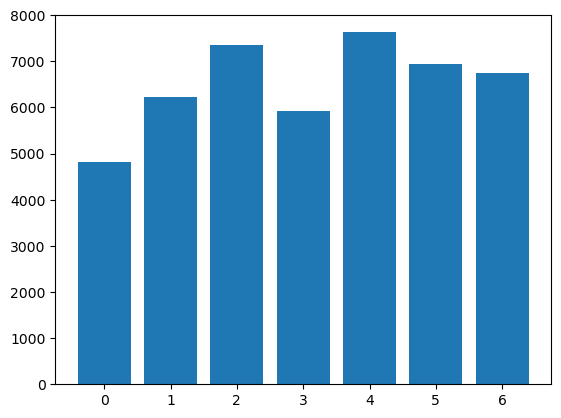

In [7]:
plt_datas_x = []
plt_datas_y = []

for i in range(0,7):
    plt_datas_x.append(i)
    plt_datas_y.append(len(df_train_data[df_train_data["topic_idx"] == i]))

print(plt_datas_y)
plt.bar(plt_datas_x, plt_datas_y)
plt.show()

- <span style="font-weight:800;">결과 분석</span>
    - 분류0번과 4번 차이가 꽤 크다.<br>
    - 무시할 수 있는 차이라 생각한다.<br><br>

- <span style="font-weight:800;">해결책</span>
    - 일단 데이터 전처리 끝난 후에 확인후 생각한다.

#### title 길이 분포

뉴스제목 길이 최댓값: 44
뉴스제목 길이 최솟값: 4
뉴스제목 길이 평균값: 27.330551539843167
뉴스제목 길이 표준편차: 4.968117227208428
뉴스제목 길이 중간값: 28.0
뉴스제목 길이 제1사분위: 25.0
뉴스제목 길이 제3사분위: 31.0
뉴스제목 길이 상위1%: 36.0
뉴스제목 길이 하위1%: 12.0
뉴스제목 길이 하위0.5%: 10.0


Text(0, 0.5, 'Number of title')

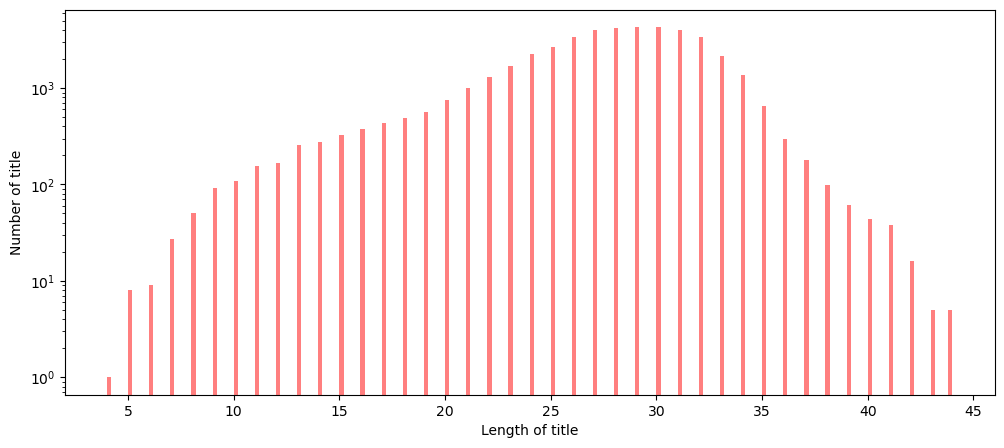

In [8]:
train_lengths = df_train_data["title"].apply(len)

print(f'뉴스제목 길이 최댓값: {np.max(train_lengths)}')
print(f'뉴스제목 길이 최솟값: {np.min(train_lengths)}')
print(f'뉴스제목 길이 평균값: {np.mean(train_lengths)}')
print(f'뉴스제목 길이 표준편차: {np.std(train_lengths)}')
print(f'뉴스제목 길이 중간값: {np.median(train_lengths)}')
print(f'뉴스제목 길이 제1사분위: {np.percentile(train_lengths, 25)}')
print(f'뉴스제목 길이 제3사분위: {np.percentile(train_lengths, 75)}')
print(f'뉴스제목 길이 상위1%: {np.percentile(train_lengths, 99)}')
print(f'뉴스제목 길이 하위1%: {np.percentile(train_lengths, 1)}')
print(f'뉴스제목 길이 하위0.5%: {np.percentile(train_lengths, 0.5)}')

plt.figure(figsize=(12,5))
plt.hist(train_lengths, bins=200, alpha=0.5, color='r', label='word')
plt.yscale('log')
plt.xlabel('Length of title')
plt.ylabel('Number of title')

#### wordcloud 분석

(-0.5, 799.5, 599.5, -0.5)

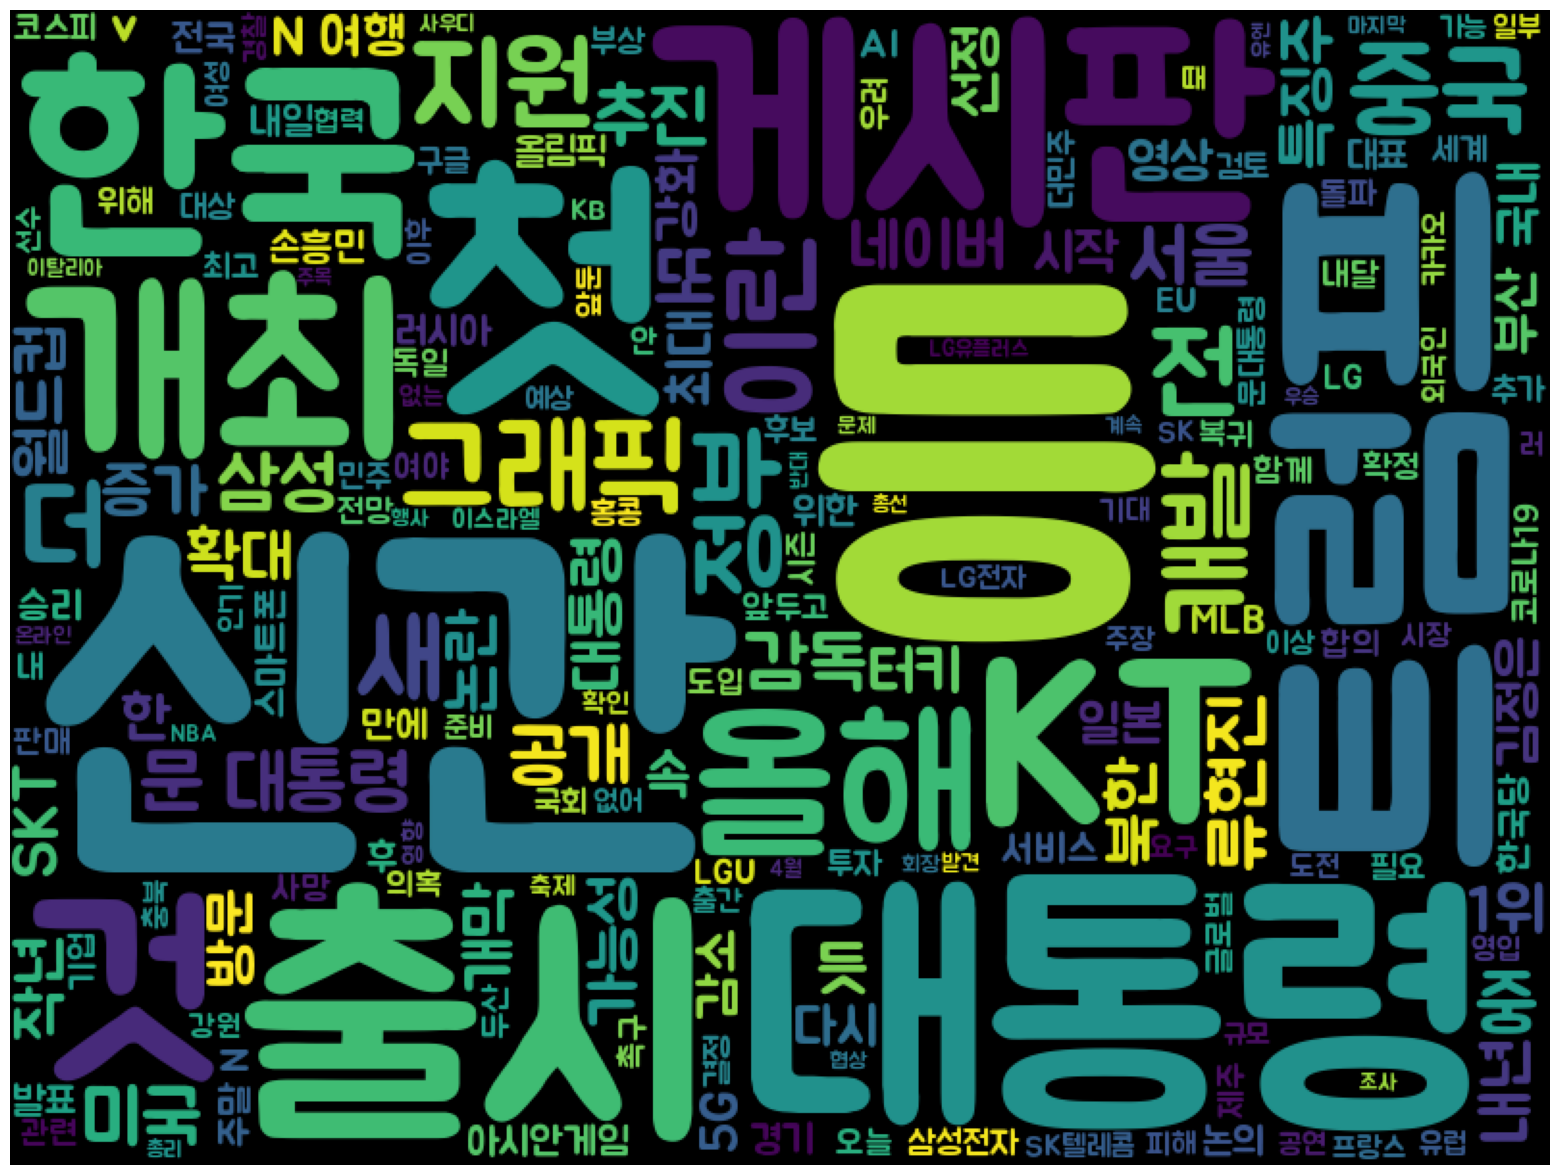

In [9]:
from wordcloud import WordCloud

FontPath = 'C:\\Users\\momo\\AppData\\Local\\Microsoft\\Windows\\Fonts\\BMJUA_ttf.ttf'
cloud = WordCloud(width=800, height=600, font_path=FontPath).generate(" ".join(df_train_data["title"]))
plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')

- <span style="font-weight:800;">결과 분석</span><br><br>
    - html 태그는 보이지 않음
    - 한글자 and 불용어들이 조금씩 보임<br><br>

- <span style="font-weight:800;">해결책</span>
    - html태그 제거는 안해도 될 듯
    - 한글자 and 불용어 제거 전처리 과정을 거쳐야 함

## 데이터 전처리 확인
1. 불용어 제거
2. "…"같은 특수문자가 한글과 붙어 있음. 단순 띄어쓰기로 구분하기에는 제약이 크다. 형태소 분석기로 분리해서 전처리하는게 맞음
3. 뉴스제목 길이 하위 0.5% 제거
4. [선택] 위의 전처리 한 후에도 topic_idx(주제 분류) 분포 차이가 많이 나는 경우에 주제 분류를 맞춰준다
5. 다중선택임 -> 원핫 인코딩

### 1. 불용어 제거, 2 형태소 분리 처리

In [10]:
kkma.pos('어버이날 맑다가 흐려져…남부지방 옅은 황사')

[('어버이날', 'NNG'),
 ('맑', 'VV'),
 ('다가', 'ECD'),
 ('흐리', 'VV'),
 ('어', 'ECS'),
 ('지', 'VXV'),
 ('어', 'ECS'),
 ('…', 'SE'),
 ('남부', 'NNG'),
 ('지방', 'NNG'),
 ('옅', 'VA'),
 ('은', 'ETD'),
 ('황사', 'NNG')]

In [11]:
print(re.compile(r"^(?:S|P)").match('ds'))

None


In [12]:
from nltk.corpus import stopwords

def dataPreprocessing(title):
    ## 형태소 분리 (일단, 특수문자만 처리해보고 결과가 너무 안좋으면 형태소 분석기)
    # title = re.sub(r"…|!|~|∼|·", " ", title).strip()
    
    # 형태소 분리
    # 특수기호 제거
    kkma_title = kkma.pos(title)
    kkma_title_list = map(lambda v: v[0], filter(lambda v: re.compile(r"^(?:N|V)").match(v[1]), kkma_title))

    new_title = ' '.join(kkma_title_list)

    # 불용어 제거
    stops_en = list(set(stopwords.words("english")))
    stops_ko = utils.stopwords("ko2")
    stops = stops_en + stops_ko

    title_words = new_title.split()
    title_words = [tt for tt in title_words if tt not in stops]
    clean_title = ' '.join(title_words)

    return clean_title

### 2. 뉴스제목(문자열)이 너무 짧은 경우 (하위 0.5%) 잘라냄

In [13]:
df_train_data = df_train_data[df_train_data["title"].str.len() > np.percentile(train_lengths, 0.5)]

### 전처리된 데이터를 dataframe에 새로운 컬럼으로 추가

In [14]:
df_train_data["cleaned_title"] = df_train_data["title"].apply(lambda v: dataPreprocessing(v))

C:\Users\momo\AppData\Local\Temp\ipykernel_61628\1642964969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_data["cleaned_title"] = df_train_data["title"].apply(lambda v: dataPreprocessing(v))


In [15]:
df_train_data = pd.get_dummies(df_train_data, prefix=['topic_idx'], columns=['topic_idx'])

In [16]:
df_train_data

,index,title,cleaned_title,topic_idx_0,topic_idx_1,topic_idx_2,topic_idx_3,topic_idx_4,topic_idx_5,topic_idx_6
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,인천 핀란드 항공기 결항 휴가 철 여행객 분통,0,0,0,0,1,0,0
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,실리콘 밸리 넘어서 글 15 조 원 들이 전역 거점,0,0,0,0,1,0,0
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,외무 긴장 완화 해결책 미국 경제 전쟁 멈추,0,0,0,0,1,0,0
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,클린턴 측근 기업 특수 관계 조명 공과 맞물리 종합,0,0,0,0,1,0,0
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,시진 트럼프 중미 무역 협상 조 속 타결 희망,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,금융 미국 제휴 선진국 시장 공략,0,1,0,0,0,0,0
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,1 보 서울시 교육청 신종 코로나 확산 개학 연기 휴업 검토,0,0,1,0,0,0,0
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,게시판 키 움 증권 2020 키우 영웅전 실전 투자 대회,0,1,0,0,0,0,0
45652,45652,답변하는 배기동 국립중앙박물관장,답변 배 기동 국립 중앙 박물관,0,0,1,0,0,0,0


## 문자 데이터 벡터(토큰)화

### 텍스트 토큰화 (tf preprocessing tokenizer 이용)

In [17]:
train_cleaned_titles = list(df_train_data["cleaned_title"])
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_cleaned_titles)
text_sequences = tokenizer.texts_to_sequences(train_cleaned_titles)

print(train_cleaned_titles[0])
print(text_sequences[0])

인천 핀란드 항공기 결항 휴가 철 여행객 분통
[347, 4710, 2479, 4976, 1612, 440, 2762, 7910]


### 단어사전

In [18]:
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0
print(f'전체 단어 개수: {len(word_vocab)}')
word_vocab

전체 단어 개수: 21910


{'종합': 1,
 '2': 2,
 '1': 3,
 '3': 4,
 '원': 5,
 '5': 6,
 '명': 7,
 '김': 8,
 '만': 9,
 '대통령': 10,
 '전': 11,
 '위': 12,
 '4': 13,
 '억': 14,
 '한국': 15,
 '개': 16,
 '보': 17,
 '대': 18,
 '천': 19,
 '6': 20,
 '8': 21,
 '주': 22,
 '10': 23,
 '시': 24,
 '7': 25,
 '차': 26,
 '중': 27,
 '연': 28,
 '감독': 29,
 '출시': 30,
 '호': 31,
 '9': 32,
 '문': 33,
 '경기': 34,
 '폰': 35,
 '승': 36,
 '게시판': 37,
 '조': 38,
 '북': 39,
 '없': 40,
 '트럼프': 41,
 '프로': 42,
 '삼성': 43,
 '안': 44,
 '서울': 45,
 '투자': 46,
 '정부': 47,
 '개발': 48,
 '리': 49,
 '농구': 50,
 '민': 51,
 '정상': 52,
 '신간': 53,
 '당': 54,
 '현대': 55,
 '분기': 56,
 '지원': 57,
 '대표': 58,
 '박': 59,
 '손': 60,
 '유': 61,
 '20': 62,
 '시장': 63,
 '기술': 64,
 '홍': 65,
 '금융': 66,
 '회담': 67,
 '중국': 68,
 '강': 69,
 '30': 70,
 '타': 71,
 '미': 72,
 '은행': 73,
 '후': 74,
 '기업': 75,
 '올해': 76,
 '19': 77,
 '배구': 78,
 '민주': 79,
 '피': 80,
 '새': 81,
 '선': 82,
 '속': 83,
 '스마트': 84,
 '개최': 85,
 '국민': 86,
 '세계': 87,
 '최고': 88,
 '르': 89,
 '러': 90,
 '핵': 91,
 '부': 92,
 '축구': 93,
 '공개': 94,
 '미국': 95,
 '코로나': 96,


### 단어 패딩 처리

In [19]:
# 문장 최대 길이
MAX_SEQUENCES_LENGTH = max(map(len, text_sequences))

train_inputs = preprocessing.sequence.pad_sequences(text_sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')
print(train_inputs.shape)

train_labels = []
for i in range(0, len(df_train_data)):
    train_labels.append([ df_train_data.iloc[i][f'topic_idx_{j}'] for j in range(0, 7) ])
train_labels = np.array(train_labels)

(45359, 20)


### input 데이터 및 전처리 데이터 numpy 및 csv 로 저장

In [20]:
PATH_DATA_INPUT = './datas/inputs'

if not os.path.exists(PATH_DATA_INPUT):
    os.mkdir(PATH_DATA_INPUT)

with open(PATH_DATA_INPUT+'/train_input.npy', 'wb') as f:
    np.save(f, train_inputs)
with open(PATH_DATA_INPUT+'/train_labels.npy', 'wb') as f:
    np.save(f, train_labels)

df_train_data.to_csv(PATH_DATA_INPUT + '/train_df.csv', index=False)

with open(PATH_DATA_INPUT + '/word_vocab.json', 'w') as f:
    json.dump(word_vocab, f, ensure_ascii=False)

## 모델 정의

In [21]:
print(train_inputs[0])
print(train_labels[0])

[ 347 4710 2479 4976 1612  440 2762 7910    0    0    0    0    0    0
    0    0    0    0    0    0]
[0 0 0 0 1 0 0]


### 모델 하이파라미터 정의

In [22]:
MODEL_ARGS = {
    "output_dim": 100,
    "dropout": 0.2,
    "LSTM_units": 128,
    "learning_rate": 0.001,
    "earlystopping_monitor": "val_accuracy",
    "earlystopping_patience": 10,
    "modelcheckpoint_monitor": "val_accuracy",

    "batch_size": 128,
    "epochs": 30,
    "valid_split": 0.1,
    "ouput_units_len": 7 # 0~6
}

### 모델 구현

#### RNN

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.activations import tanh, sigmoid

model = Sequential([
    Embedding(input_dim=len(word_vocab), output_dim=MODEL_ARGS["output_dim"]),
    Dropout(MODEL_ARGS["dropout"]),
    LSTM(MODEL_ARGS["LSTM_units"], return_sequences=True),
    LSTM(MODEL_ARGS["LSTM_units"]),
    Dropout(MODEL_ARGS["dropout"]),
    Dense(units=MODEL_ARGS["LSTM_units"], activation=tanh),
    Dropout(MODEL_ARGS["dropout"]),
    Dense(units=MODEL_ARGS["ouput_units_len"], activation=sigmoid)
])

model.summary()

model.compile(optimizer=Adam(MODEL_ARGS["learning_rate"]),
              loss=BinaryCrossentropy(),
              metrics=[
                BinaryAccuracy(name='accuracy')
              ])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2191000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

#### 모델학습 진행중 콜백함수 사전 정의

In [24]:
cb_earlystop = EarlyStopping(monitor=MODEL_ARGS["earlystopping_monitor"], patience=MODEL_ARGS["earlystopping_patience"])

PATH_DATA_OUTPUT = './datas/output'
PATH_CHKPOINT = PATH_DATA_OUTPUT + '/chkpoints'
if not os.path.exists(PATH_CHKPOINT):
    os.makedirs(PATH_CHKPOINT)

PATH_CHKPOINT += '/weights.h5'

cb_chkpoint = ModelCheckpoint(PATH_CHKPOINT, monitor=MODEL_ARGS["modelcheckpoint_monitor"], verbose=1, save_best_only=True, save_weights_only=True)

## 모델 학습

In [25]:
print(train_inputs.shape)
print(train_labels.shape)

(45359, 20)
(45359, 7)


In [26]:
history = model.fit(
    train_inputs,
    train_labels,
    batch_size=MODEL_ARGS["batch_size"],
    epochs=MODEL_ARGS["epochs"],
    validation_split=MODEL_ARGS["valid_split"],
    callbacks=[cb_earlystop, cb_chkpoint]
)

Epoch 1/30
319/319 [==============================] - 56s 153ms/step - loss: 0.3425 - accuracy: 0.8751 - val_loss: 0.2560 - val_accuracy: 0.8857

Epoch 00001: val_accuracy improved from -inf to 0.88568, saving model to ./datas/output/chkpoints\weights.h5
Epoch 2/30
319/319 [==============================] - 12s 39ms/step - loss: 0.1498 - accuracy: 0.9454 - val_loss: 0.1644 - val_accuracy: 0.9380

Epoch 00002: val_accuracy improved from 0.88568 to 0.93796, saving model to ./datas/output/chkpoints\weights.h5
Epoch 3/30
319/319 [==============================] - 48s 151ms/step - loss: 0.0995 - accuracy: 0.9664 - val_loss: 0.1584 - val_accuracy: 0.9413

Epoch 00003: val_accuracy improved from 0.93796 to 0.94130, saving model to ./datas/output/chkpoints\weights.h5
Epoch 4/30
319/319 [==============================] - 49s 118ms/step - loss: 0.0762 - accuracy: 0.9756 - val_loss: 0.1656 - val_accuracy: 0.9421

Epoch 00004: val_accuracy improved from 0.94130 to 0.94205, saving model to ./datas/

## 모델 학습 결과 확인

### model history 그래프 확인

In [27]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

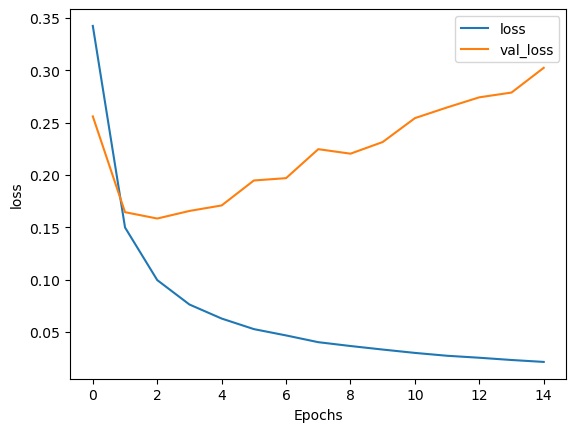

In [28]:
plot_graphs(history, 'loss')

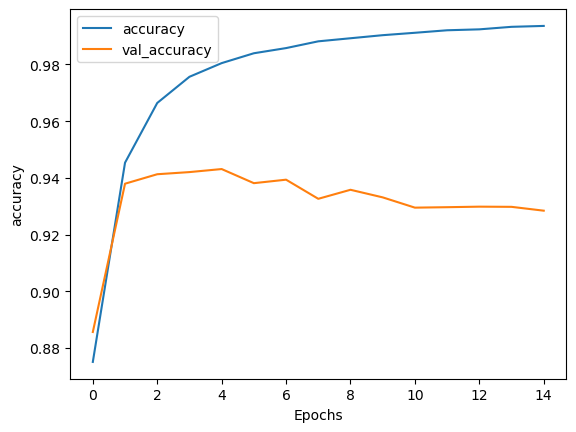

In [29]:
plot_graphs(history, 'accuracy')

## 학습 결과 데이터 저장

### 모델 가중치, 모델을 h5 파일 형태로 저장

In [30]:
PATH_MODEL = PATH_DATA_OUTPUT + '/models'

if not os.path.exists(PATH_MODEL):
    os.mkdir(PATH_MODEL)

model.save_weights(PATH_MODEL + '/weights.h5', options='')
model.save(PATH_MODEL + '/model.h5')

### 모델을 pickle 모듈로 저장 (웹 서비스를 위해)

#### 모델 pickle 저장

In [37]:
with open(PATH_MODEL + '/model.pkl', 'wb') as f:
    pickle.dump(model, f)
# joblib.dump(model, PATH_MODEL + '/model.pkl')

TypeError: cannot pickle 'weakref' object

#### 사용된 tokenizer 저장

In [ ]:
with open(PATH_MODEL + '/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

## 모델 검증

### 모델 예측하기

In [38]:
df_topic_dict

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [ ]:
df_test_data

In [ ]:
clean_test_titles = []
for title in df_test_data['title']:
    clean_test_titles.append(dataPreprocessing(title))

df_cleaned_test_data = pd.DataFrame({ 'index': df_test_data['index'], 'title': clean_test_titles })
test_id = np.array(df_test_data['index'])

text_sequences_test = tokenizer.texts_to_sequences(clean_test_titles)
test_inputs = preprocessing.sequence.pad_sequences(text_sequences_test, maxlen=MAX_SEQUENCES_LENGTH, padding='post')

predictions = model.predict(test_inputs, batch_size=MODEL_ARGS["batch_size"])

### 예측한 결과 csv 형식으로 저장

In [ ]:
resultDFs = []
for i,v in enumerate(predictions):
    resultDF_item = { "index": i }
    for j in range(0, 6):
        resultDF_item[f'topic_idx_{j}'] = v[j]
    resultDF_item["max_topic_index"] = np.where(v == max(v))[0][0]
    resultDF_item["max"] = max(v)

    resultDF_item["title"] = df_test_data['title'][i]
    resultDF_item["topic"] = df_topic_dict[df_topic_dict["topic_idx"] == resultDF_item["max_topic_index"]].iloc[0]["topic"]

    resultDFs.append(resultDF_item)

output = pd.DataFrame(resultDFs)
output.to_csv(PATH_DATA_OUTPUT + '/news_predict.csv', index=False, quoting=3)